<a href="https://colab.research.google.com/github/fuaadrahman/project/blob/main/Fruit_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fuaadrahman","key":"1565f0bce70a01d5a8636ac4defcb19f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sshikamaru/fruit-recognition

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition
License(s): other
 99% 101M/102M [00:00<00:00, 1.05GB/s]
100% 102M/102M [00:00<00:00, 1.05GB/s]


In [5]:
!unzip fruit-recognition.zip -d fruit-dataset1

Streaming output truncated to the last 5000 lines.
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: fruit-dataset1/train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: fruit-dataset1/train/trai

In [6]:
!ls fruit-dataset1

sampleSubmission.csv  test  train


# Preprocessing

In [7]:
import shutil
TRAIN_DIR = 'fruit-dataset1/train/train'
TEST_DIR = 'fruit-dataset1/test/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(TRAIN_DIR,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',subset='training')
val_gen = train_datagen.flow_from_directory(TRAIN_DIR,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',subset='validation')
print("\ntest data...")
test_dir_source = TEST_DIR
test_dir_processed_parent = 'fruit-dataset/test_processed'
test_dir_processed_child = os.path.join(test_dir_processed_parent, 'test_images')

if not os.path.exists(test_dir_processed_child):
    os.makedirs(test_dir_processed_child)
    for file_name in os.listdir(test_dir_source):
        source_file_path = os.path.join(test_dir_source, file_name)
        destination_file_path = os.path.join(test_dir_processed_child, file_name)
        if os.path.isfile(source_file_path):
            shutil.move(source_file_path, destination_file_path)

test_gen = test_datagen.flow_from_directory(test_dir_processed_parent,target_size=IMG_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',shuffle=False # Important for correct evaluation)

num_classes = train_gen.num_classes
print(f"Number of classes found: {num_classes}")

Creating training and validation generators...
Found 13493 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.

Preparing test data...
Found 5641 images belonging to 1 classes.
Number of classes found: 33


# Model Training

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = train_gen.num_classes
print(f"Number of classes found: {num_classes}")

base_model = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]


Number of classes found: 33
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
print("\nStarting model training...")
history = model.fit(train_gen,validation_data=val_gen,epochs=20,callbacks=callbacks)


Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6913 - loss: 1.1538

422/422 ━━━━━━━━━━━━━━━━━━━━ 230s 502ms/step - accuracy: 0.6916 - loss: 1.1523 - val_accuracy: 0.9845 - val_loss: 0.0584
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9561 - loss: 0.1437

422/422 ━━━━━━━━━━━━━━━━━━━━ 186s 441ms/step - accuracy: 0.9561 - loss: 0.1436 - val_accuracy: 0.9923 - val_loss: 0.0230
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9759 - loss: 0.0808

422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 440ms/step - accuracy: 0.9759 - loss: 0.0808 - val_accuracy: 0.9979 - val_loss: 0.0083
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 186s 440ms/step - accuracy: 0.9781 - loss: 0.0724 - val_accuracy: 0.9970 - val_loss: 0.0143
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9795 - loss: 0.0646

422/422 ━━━━━━━━━━━━━━━━━━━━ 186s 440ms/step - accuracy: 0.9795 - loss: 0.0646 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 439ms/step - accuracy: 0.9841 - loss: 0.0497 - val_accuracy: 0.9982 - val_loss: 0.0065
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 190s 451ms/step - accuracy: 0.9851 - loss: 0.0507 - val_accuracy: 0.9982 - val_loss: 0.0071
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 189s 447ms/step - accuracy: 0.9844 - loss: 0.0567 - val_accuracy: 0.9973 - val_loss: 0.0062
Epoch 9/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 439ms/step - accuracy: 0.9866 - loss: 0.0447 - val_accuracy: 0.9985 - val_loss: 0.0077
Epoch 10/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9864 - loss: 0.0455

422/422 ━━━━━━━━━━━━━━━━━━━━ 187s 444ms/step - accuracy: 0.9864 - loss: 0.0455 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 11/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 439ms/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9979 - val_loss: 0.0063
Epoch 12/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 205s 447ms/step - accuracy: 0.9866 - loss: 0.0442 - val_accuracy: 0.9988 - val_loss: 0.0047
Epoch 13/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 450ms/step - accuracy: 0.9855 - loss: 0.0464 - val_accuracy: 0.9982 - val_loss: 0.0051
Epoch 14/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 452ms/step - accuracy: 0.9883 - loss: 0.0429 - val_accuracy: 0.9982 - val_loss: 0.0047
Epoch 15/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 438ms/step - accuracy: 0.9901 - loss: 0.0331 - val_accuracy: 0.9979 - val_loss: 0.0046


In [11]:
from google.colab import files
try:
    files.download('best_model.h5')
    print("Model file downloaded successfully!")
except FileNotFoundError:
    print("Model file not found. Please ensure 'best_model.h5' exists.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model file downloaded successfully!


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 26,355,621 (100.54 MB)

 Trainable params: 8,032,545 (30.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 16,065,092 (61.28 MB)

In [12]:
print("\nEvaluating model on validation set for metrics...")
val_gen.reset()
Y_pred_val = model.predict(val_gen)
y_pred_classes_val = np.argmax(Y_pred_val, axis=1)

y_true_val = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\nClassification Report (Validation Set):")
print(classification_report(y_true_val, y_pred_classes_val, target_names=class_labels))

print("\nEvaluating model on test set for overall accuracy...")
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Evaluating model on validation set for metrics...
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 393ms/step

Classification Report (Validation Set):
                    precision    recall  f1-score   support

    Apple Braeburn       0.04      0.04      0.04        98
Apple Granny Smith       0.06      0.06      0.06        98
           Apricot       0.02      0.02      0.02        98
           Avocado       0.02      0.02      0.02        85
            Banana       0.02      0.02      0.02        98
         Blueberry       0.03      0.03      0.03        92
      Cactus fruit       0.02      0.02      0.02        98
        Cantaloupe       0.00      0.00      0.00        98
            Cherry       0.03      0.03      0.03        98
        Clementine       0.00      0.00      0.00        98
              Corn       0.01      0.01      0.01        90
     Cucumber Ripe       0.03      0.03      0.03        78
        Grape Blue       0.06      0.06      0.06       196
              Kiwi     

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.0269 - loss: 1076.1567
Test Accuracy: 0.0300
Test Loss: 1071.2079


# Visualisation

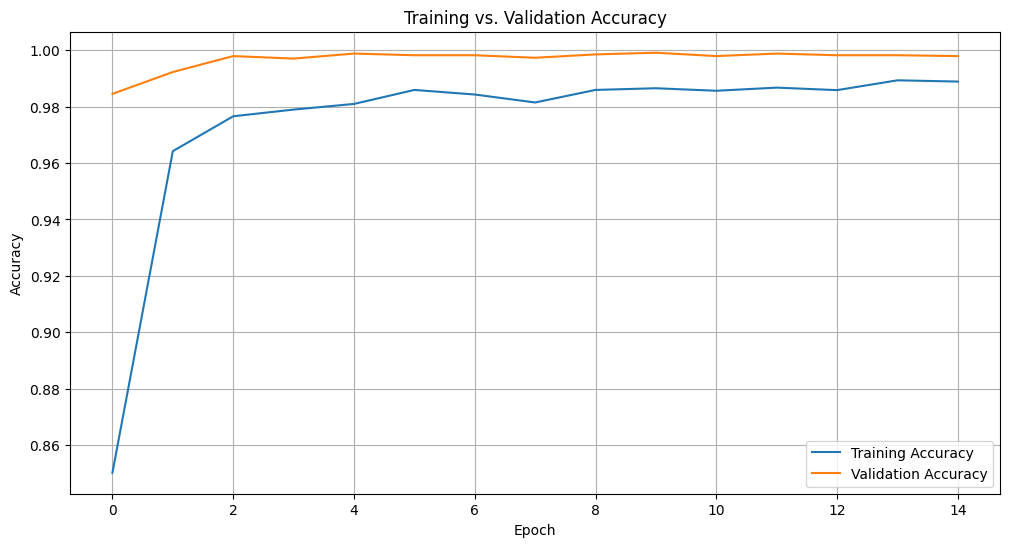

In [15]:
#training and validation accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

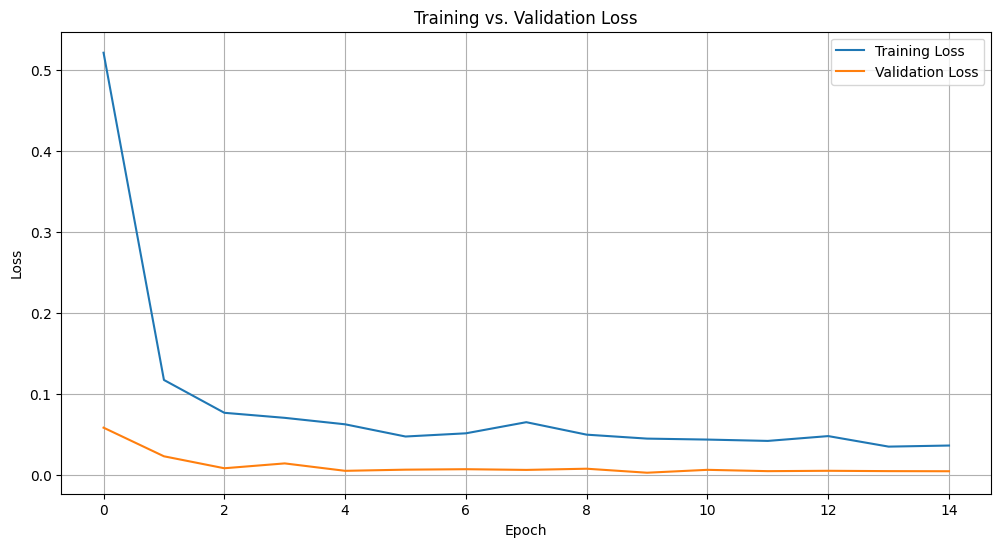

In [16]:
#training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

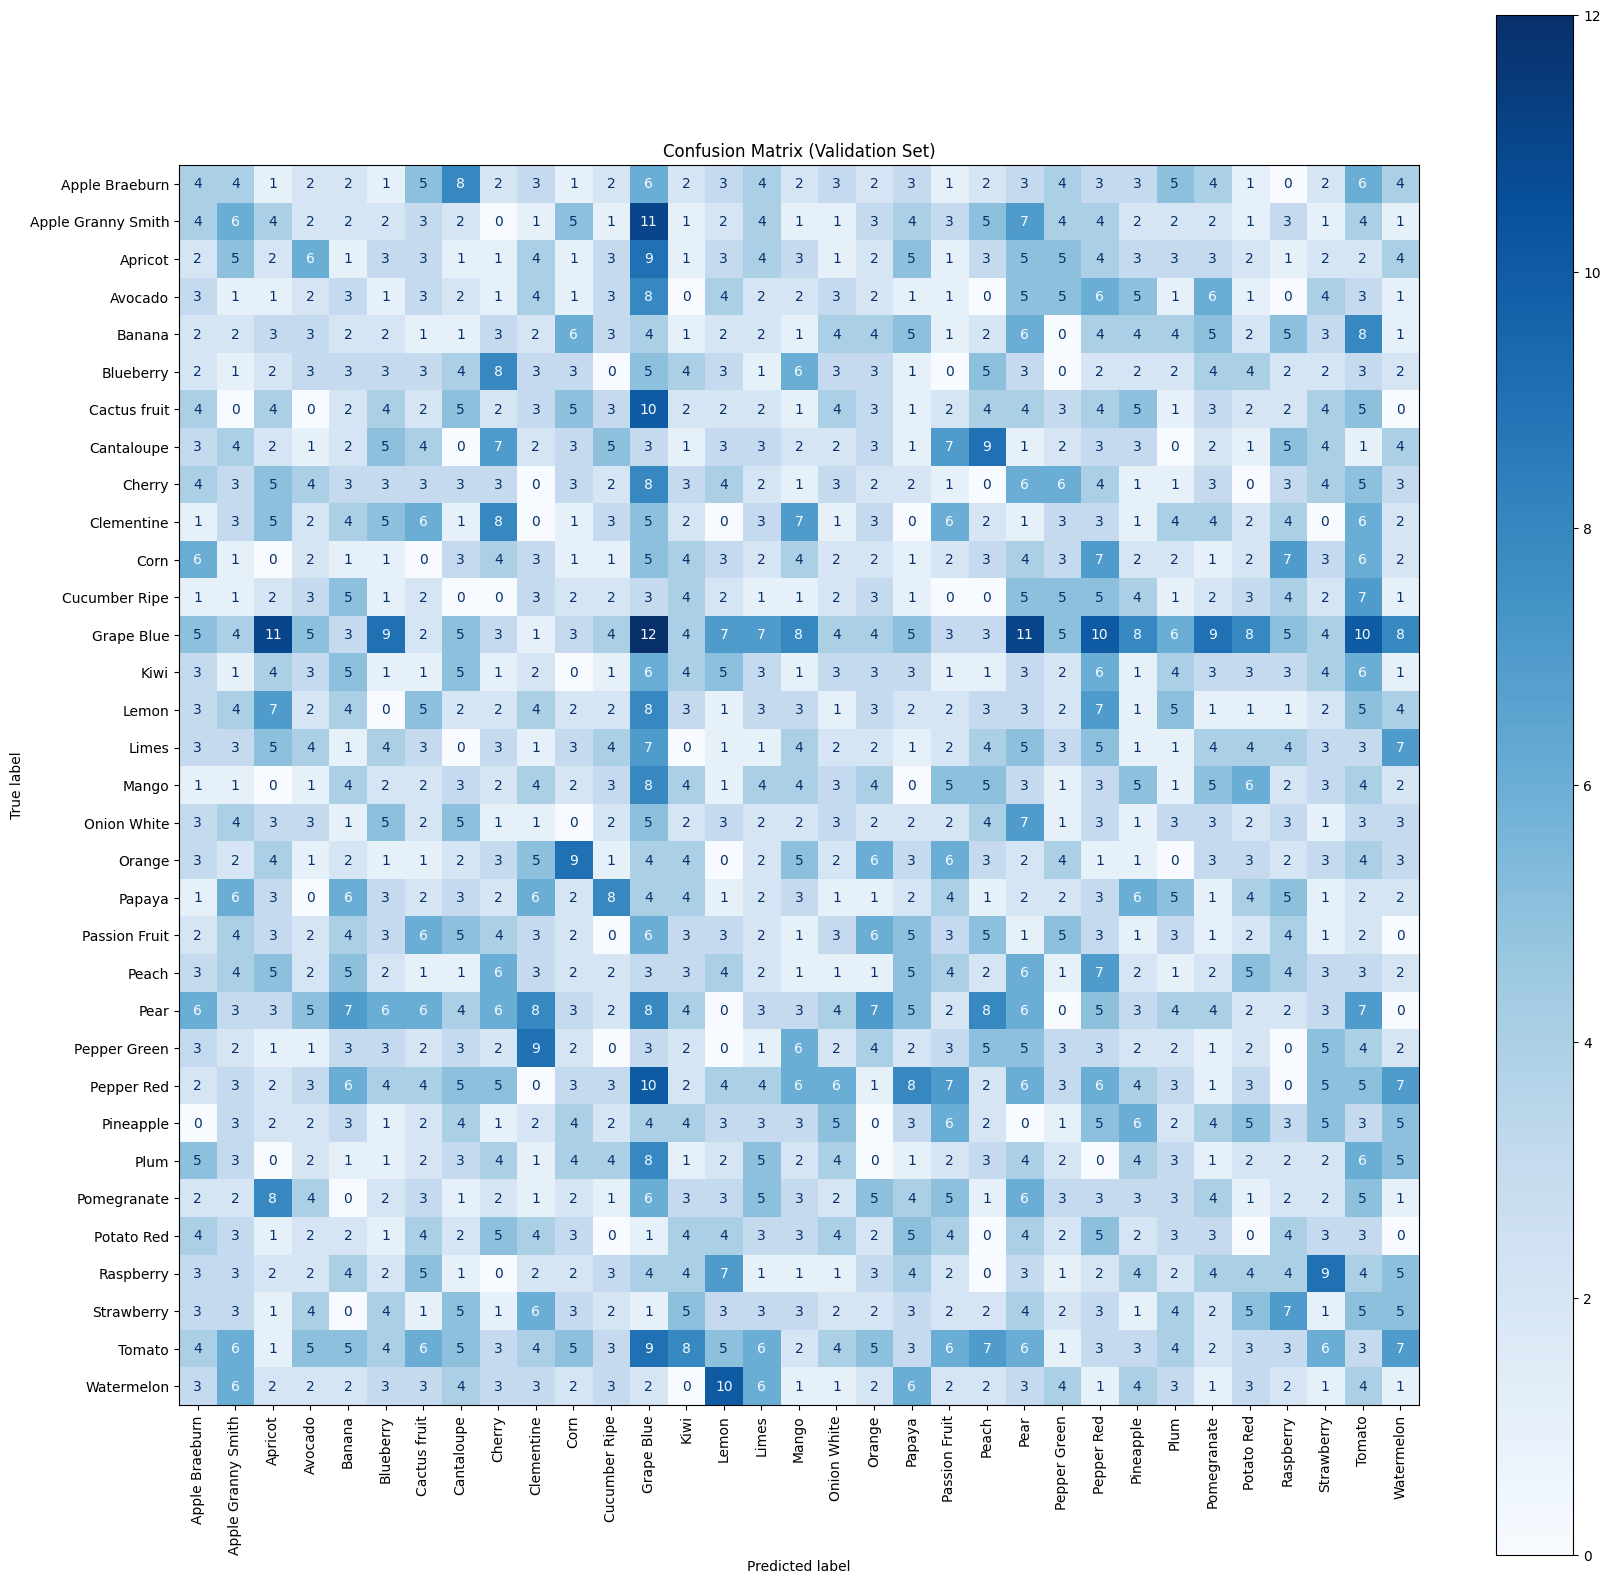

In [14]:
#confusion matrix for validation set
cm = confusion_matrix(y_true_val, y_pred_classes_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.show()